# Elastic Optical Network - Pre-Disaster Simulation Analysis (Refactored)

This notebook has been refactored to use modular analysis and visualization packages:

## Modules Used:

### Analysis (`simulador.analysis`)
- **`topology_analysis`**: Network structure analysis, critical disaster nodes
- **`metrics_calculator`**: Availability, blocking rates, performance metrics
- **`dataframe_filters`**: Data filtering by time, node, distance, components
- **`reporters`**: Formatted console output and reports

### Visualization (`simulador.visualization`)
- **`availability_plots`**: Availability charts and heatmaps
- **`traffic_plots`**: Traffic patterns and blocking visualizations

## Improvements:
- ✅ All inline functions removed
- ✅ Code reusable across notebooks
- ✅ Type hints and documentation
- ✅ Cleaner, more maintainable code

---


In [1]:
# Standard library
import math
import pickle
from collections import defaultdict

# Third-party
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from simpy import Environment

# Simulador - Core
from simulador import analysis
from simulador.main import Simulator
from simulador import Scenario, ScenarioGenerator, Metrics
from simulador.config.settings import NUMERO_DE_REQUISICOES, NUMERO_DE_SLOTS
from simulador import routing

# Simulador - Analysis
from simulador import analysis, visualization

# Simulador - Visualization
from simulador.visualization import (
    availability_plots,
    traffic_plots,
)

# Jupyter configuration
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load topology
TOPOLOGY = nx.read_weighted_edgelist("topology/usa", nodetype=int)

print("✓ All modules loaded successfully!")


✓ All modules loaded successfully!


### Encontra bons pontos de desastre para topologia

In [2]:
# Use topology analysis from module
results = analysis.topology_analysis.find_balanced_min_cut_for_all_nodes(TOPOLOGY)

# Extract critical node info from results
critical_info = results[0]
NODE_DESASTRE = critical_info["node"]
COMPONENTE_1 = critical_info["partitions"][0]["partition_1"]
COMPONENTE_2 = critical_info["partitions"][0]["partition_2"]
CRITICAL_EDGES = critical_info["partitions"][0]["cut_edges"]

# Print analysis
analysis.topology_analysis.print_topology_analysis_results(results[:5])

print(f"\nSelected disaster node: {NODE_DESASTRE}")
print(f"Component 1: {len(COMPONENTE_1)} nodes")
print(f"Component 2: {len(COMPONENTE_2)} nodes")
print(f"Critical edges: {len(CRITICAL_EDGES)}")


Node 9 removed: min_cut = 2, size_diff = 7
  Cut edges: [(6, 11), (8, 10)]
  Partition 1: [1, 2, 3, 4, 5, 6, 7, 8]
  Partition 2: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


Node 7 removed: min_cut = 2, size_diff = 15
  Cut edges: [(2, 3), (8, 10)]
  Partition 1: [8, 3, 4, 5]
  Partition 2: [1, 2, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


Node 17 removed: min_cut = 2, size_diff = 17
  Cut edges: [(14, 18), (22, 23)]
  Partition 1: [24, 18, 23]
  Partition 2: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22]


Node 6 removed: min_cut = 1, size_diff = 19
  Cut edges: [(2, 3)]
  Partition 1: [1, 2]
  Partition 2: [3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


Node 3 removed: min_cut = 2, size_diff = 19
  Cut edges: [(1, 6), (2, 6)]
  Partition 1: [1, 2]
  Partition 2: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
  Cut edges: [(7, 4), (5, 8)]
  Partition 1:

### Cria cenario

In [3]:
criar_e_rodar_novo_cenario = True
is_logger_active = True

In [4]:
if criar_e_rodar_novo_cenario:
    roteamentos_a_serem_testados = [
        # routing.FirstFit,
        # routing.FirstFitDisasterAware,
        routing.FirstFitSubnet,
        routing.FirstFitWeightedSubnetDisasterAware,
    ]

    cenario1, cenario2 = ScenarioGenerator.gerar_cenarios(
        TOPOLOGY,
        retorna_lista_de_requisicoes=True,
        numero_de_requisicoes=NUMERO_DE_REQUISICOES,
        lista_de_roteamentos_de_desastre=roteamentos_a_serem_testados,
        disaster_node=NODE_DESASTRE,
    )

    # Save scenarios
    with open("output/cenario_nao_disaster_aware.pkl", "wb") as file:
        pickle.dump(cenario1, file)

    with open("output/cenario_disaster_aware.pkl", "wb") as file:
        pickle.dump(cenario2, file)
else:
    # Load existing scenarios
    with open("output/cenario_nao_disaster_aware.pkl", "rb") as file:
        cenario1 = pickle.load(file)

    with open("output/cenario_disaster_aware.pkl", "rb") as file:
        cenario2 = pickle.load(file)


Link  9 6  vai falhar
Link  9 7  vai falhar
Link  9 11  vai falhar
Link  9 6  vai falhar
Link  9 7  vai falhar
Link  9 10  vai falhar
Link  9 11  vai falhar
Link  9 12  vai falhar
node_desastre 9


### Roda cenarios

In [5]:
if criar_e_rodar_novo_cenario:
    # roda cenario1
    Metrics.reseta_registrador()
    env = Environment()
    simulador: Simulator = Simulator(
        env=env, topology=TOPOLOGY, status_logger=is_logger_active, cenario=cenario1
    )
    simulador.run()
    dataframe_cenario1 = simulador.salvar_dataframe("output/dataframe_nao_disaster_aware")
dataframe1: pd.DataFrame = pd.read_csv("output/dataframe_nao_disaster_aware.csv")


10000 requests processed, time : 97
20000 requests processed, time : 193
30000 requests processed, time : 279
40000 requests processed, time : 345
50000 requests processed, time : 407
60000 requests processed, time : 469
70000 requests processed, time : 531
Link 9 -> 6 falhou no tempo 582
80000 requests processed, time : 599
Link 9 -> 7 falhou no tempo 608
Node 9 falhou no tempo 633
Link 9 -> 11 falhou no tempo 634
90000 requests processed, time : 696
100000 requests processed, time : 792
Link 9 -> 6 falhou no tempo 801
Link 9 -> 7 falhou no tempo 801
Node 9 falhou no tempo 801
Disaster finalizado no tempo 801
Link 9 -> 11 falhou no tempo 801
110000 requests processed, time : 888
120000 requests processed, time : 986
130000 requests processed, time : 1082
140000 requests processed, time : 1179


/var/folders/0k/s6m7zdf54hgbxnlcw473w_1h0000gq/T/ipykernel_42312/697241706.py:10: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe1: pd.DataFrame = pd.read_csv("output/dataframe_nao_disaster_aware.csv")


In [6]:
tempo_fim_migracao_concluida1 = Metrics.get_intance().tempo_de_migracao_concluida

In [7]:
if criar_e_rodar_novo_cenario:
    # roda cenario2
    env = Environment()
    Metrics.reseta_registrador()
    simulador: Simulator = Simulator(
        env=env, topology=TOPOLOGY, status_logger=is_logger_active, cenario=cenario2
    )
    simulador.run()
    dataframe_cenario2 = simulador.salvar_dataframe("output/dataframe_disaster_aware")



dataframe2: pd.DataFrame = pd.read_csv("output/dataframe_disaster_aware.csv")

10000 requests processed, time : 97
20000 requests processed, time : 193
30000 requests processed, time : 279
40000 requests processed, time : 345
50000 requests processed, time : 407
60000 requests processed, time : 469
70000 requests processed, time : 531
Link 9 -> 6 falhou no tempo 582
80000 requests processed, time : 599
Link 9 -> 7 falhou no tempo 608
Node 9 falhou no tempo 633
Link 9 -> 11 falhou no tempo 634
90000 requests processed, time : 696
100000 requests processed, time : 792
Link 9 -> 6 falhou no tempo 801
Link 9 -> 7 falhou no tempo 801
Node 9 falhou no tempo 801
Disaster finalizado no tempo 801
Link 9 -> 11 falhou no tempo 801
110000 requests processed, time : 888
120000 requests processed, time : 986
130000 requests processed, time : 1082
140000 requests processed, time : 1179


/var/folders/0k/s6m7zdf54hgbxnlcw473w_1h0000gq/T/ipykernel_42312/3568082540.py:13: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe2: pd.DataFrame = pd.read_csv("output/dataframe_disaster_aware.csv")


In [8]:
tempo_fim_migracao_concluida2 = Metrics.get_intance().tempo_de_migracao_concluida

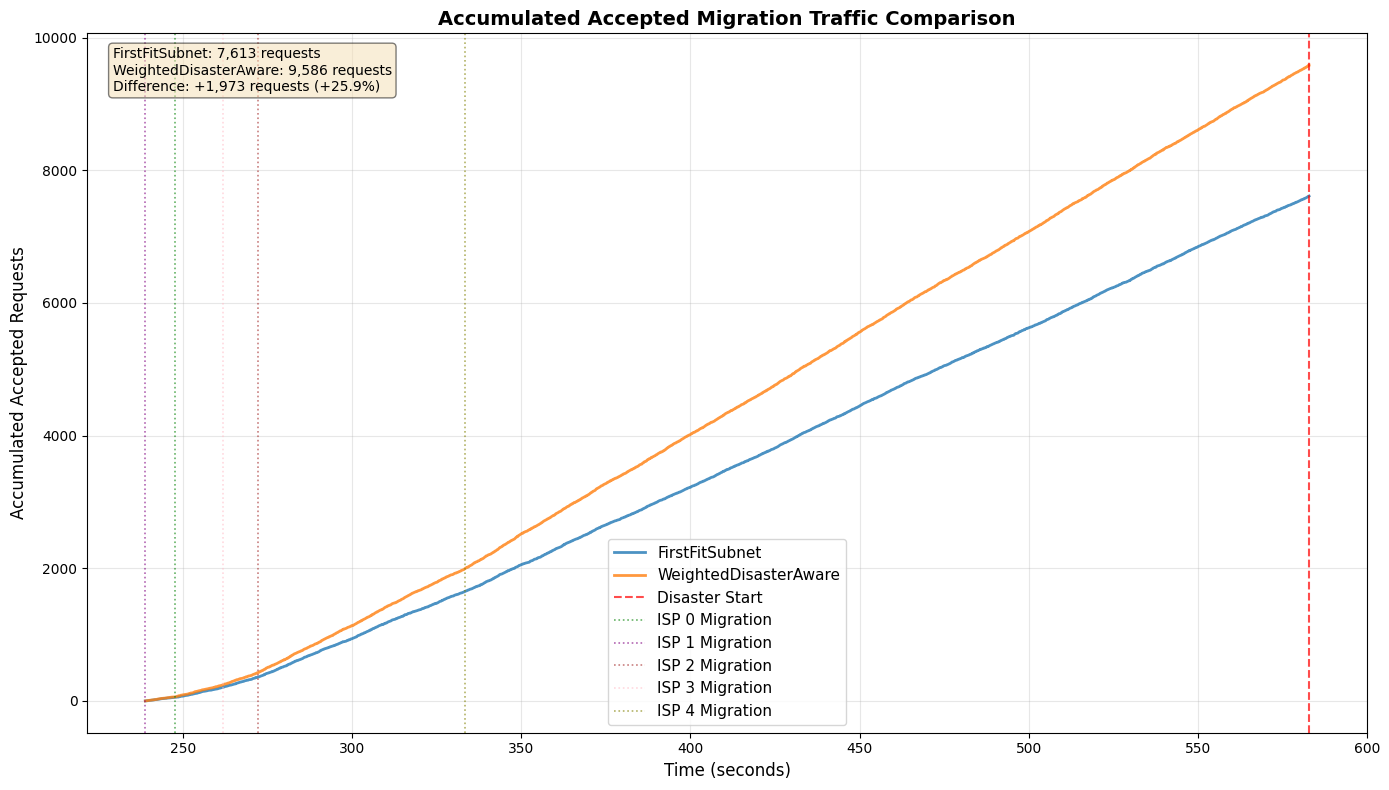

In [9]:
from simulador.visualization.accumulated_traffic import plot_accumulated_accepted_traffic

fig = plot_accumulated_accepted_traffic(
    dataframe1,
    dataframe2,
    label1="FirstFitSubnet",
    label2="WeightedDisasterAware",
    traffic_type="migration",  # "all", "migration", or "normal"
    metric="requests",         # "bandwidth" or "requests"
    scenario1=cenario1          # Required for disaster start and ISP migrations
)

In [10]:
for isp in cenario1.lista_de_isps:
    print(f"ISP {isp.isp_id} reaction time: {isp.datacenter.tempo_de_reacao}to {isp.datacenter.destination}")

isp_appearances = defaultdict(bool)
for i, req in enumerate(cenario1.lista_de_requisicoes):
    if req.requisicao_de_migracao:
        if not isp_appearances[req.src_isp_index]:
            print( f"ISP {req.src_isp_index} first enqueued migration at {req.tempo_criacao} at index {i}")
            isp_appearances[req.src_isp_index] = True


for i in range(0, 5):
    first_migration = dataframe1[
        (dataframe1["requisicao_de_migracao"]==True)
         & (dataframe1["src_isp_index"] == i)
    ].sort_values(by="tempo_criacao").head(1)
    
    if not first_migration.empty:
        tempo = first_migration["tempo_criacao"].values[0]
        index = first_migration["Index da Requisição"].values[0]
        print(f"ISP {i}: First migration at {tempo:.2f}s index {index} from {first_migration['src'].values[0]} to {first_migration['dst'].values[0]}")


ISP 0 reaction time: 247.51637559765487to 20
ISP 1 reaction time: 238.70130070386602to 23
ISP 2 reaction time: 272.24640244709644to 5
ISP 3 reaction time: 261.73259343543214to 24
ISP 4 reaction time: 333.2504084818845to 17
ISP 1 first enqueued migration at 238.78095759822796 at index 24686
ISP 0 first enqueued migration at 247.5320898102214 at index 25653
ISP 3 first enqueued migration at 261.82669569237726 at index 27527
ISP 2 first enqueued migration at 272.3060566490728 at index 28882
ISP 4 first enqueued migration at 333.3371387874813 at index 38048
ISP 0: First migration at 247.53s index 25654 from 9 to 20
ISP 1: First migration at 238.78s index 24687 from 9 to 23
ISP 2: First migration at 272.31s index 28883 from 9 to 5
ISP 3: First migration at 261.83s index 27528 from 9 to 24
ISP 4: First migration at 333.34s index 38049 from 9 to 17


In [11]:
# Define disaster timing constants

DISASTER_START = cenario1.desastre.start

DISASTER_END = cenario1.desastre.start + cenario1.desastre.duration

print(f"Disaster period: {DISASTER_START} - {DISASTER_END}")


Disaster period: 582.9433735659915 - 801.0825198528432


In [12]:
ACTION_START_TIME = {
    isp.isp_id: isp.datacenter.tempo_de_reacao for isp in cenario1.lista_de_isps
}
DISASTER_START_TIME = min(
    [(isp.datacenter.tempo_de_reacao, isp.isp_id) for isp in cenario1.lista_de_isps]
)[0]
DISASTER_END_TIME = cenario1.desastre.start + cenario1.desastre.duration

/Users/claudio.faria/Library/Caches/pypoetry/virtualenvs/simulador-eon-pre-desastre-cLZF9wpT-py3.12/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


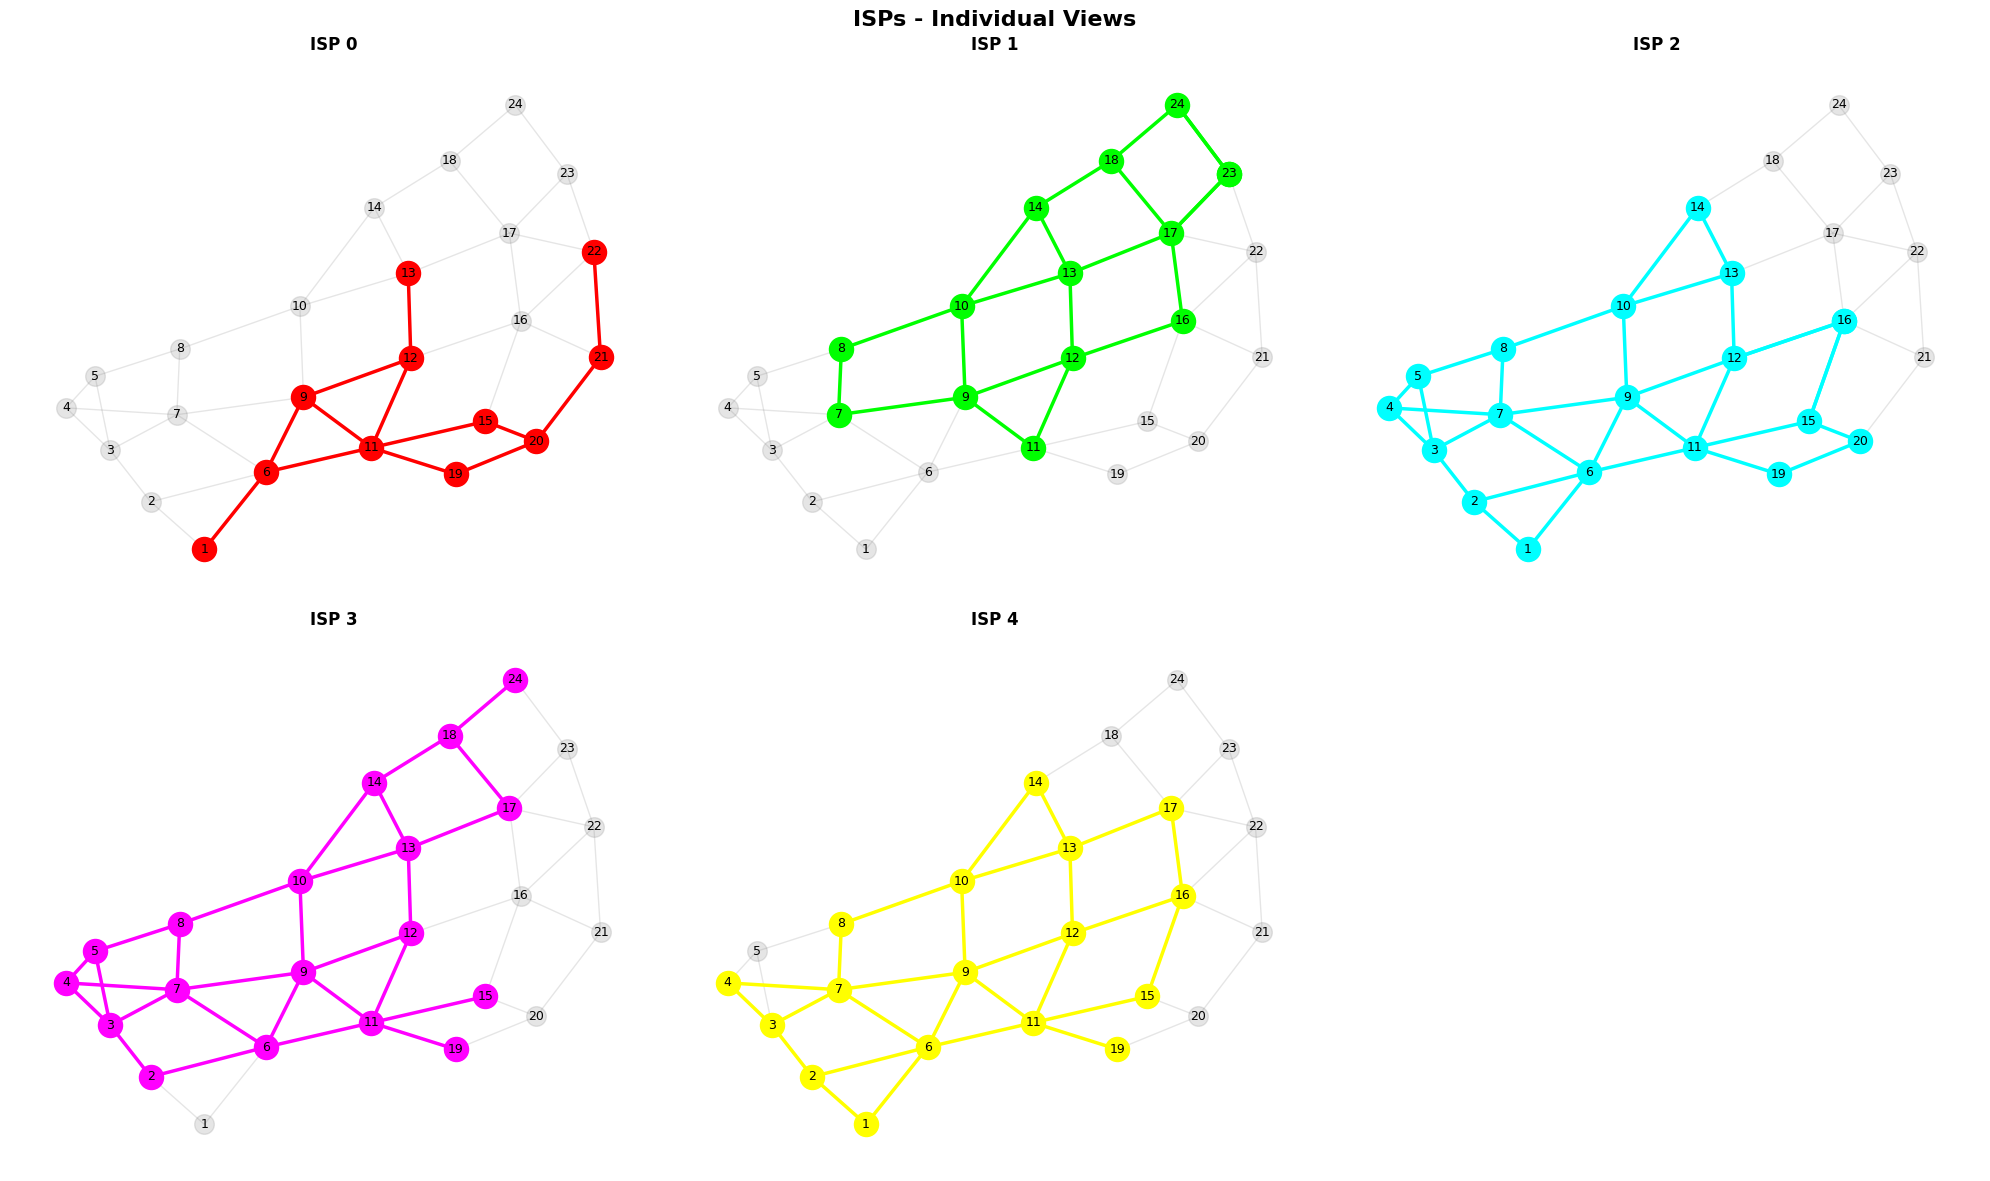

In [13]:
visualization.topology_plots.plot_isps_separately(
    TOPOLOGY,
    isp_data=cenario1,
    seed=7
)

### Plotagem de Dados Finais

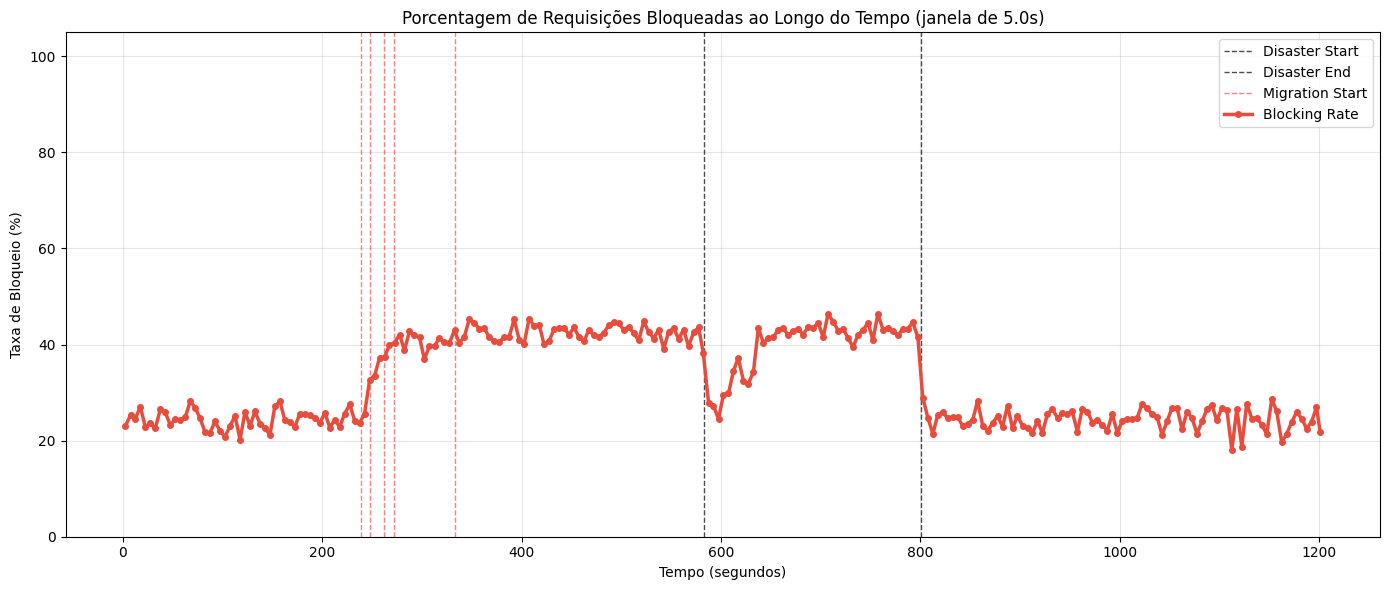

In [14]:
visualization.traffic_plots.plot_blocking_percentage_over_time(
    dataframe1,
    scenario=cenario1,

)

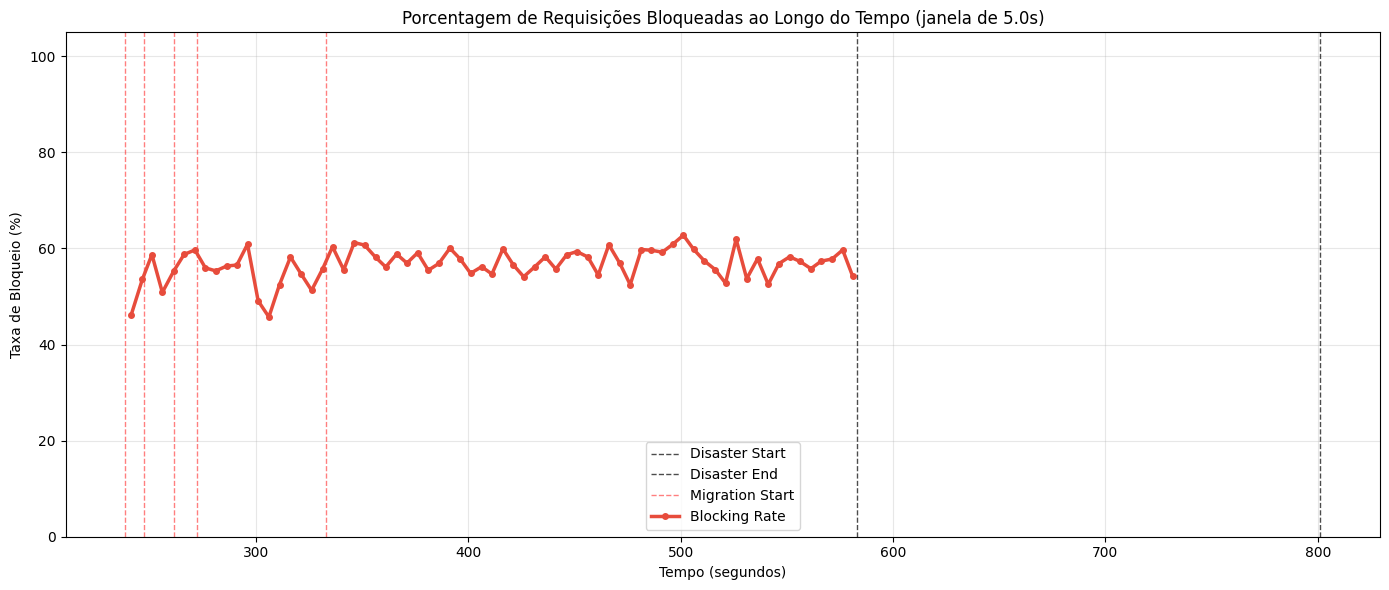

In [15]:
visualization.traffic_plots.plot_blocking_percentage_over_time(
    dataframe1[dataframe1["requisicao_de_migracao"]==True],
    scenario=cenario1,

)

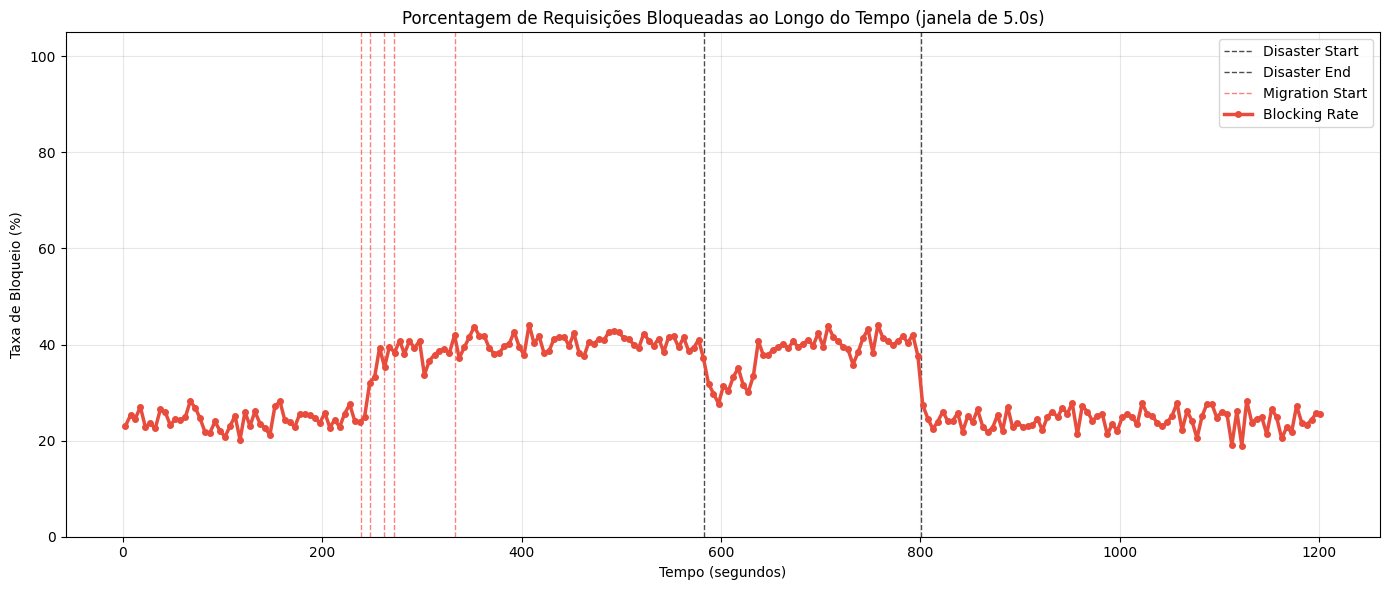

In [16]:
visualization.traffic_plots.plot_blocking_percentage_over_time(
    dataframe2,
    scenario=cenario2,

)

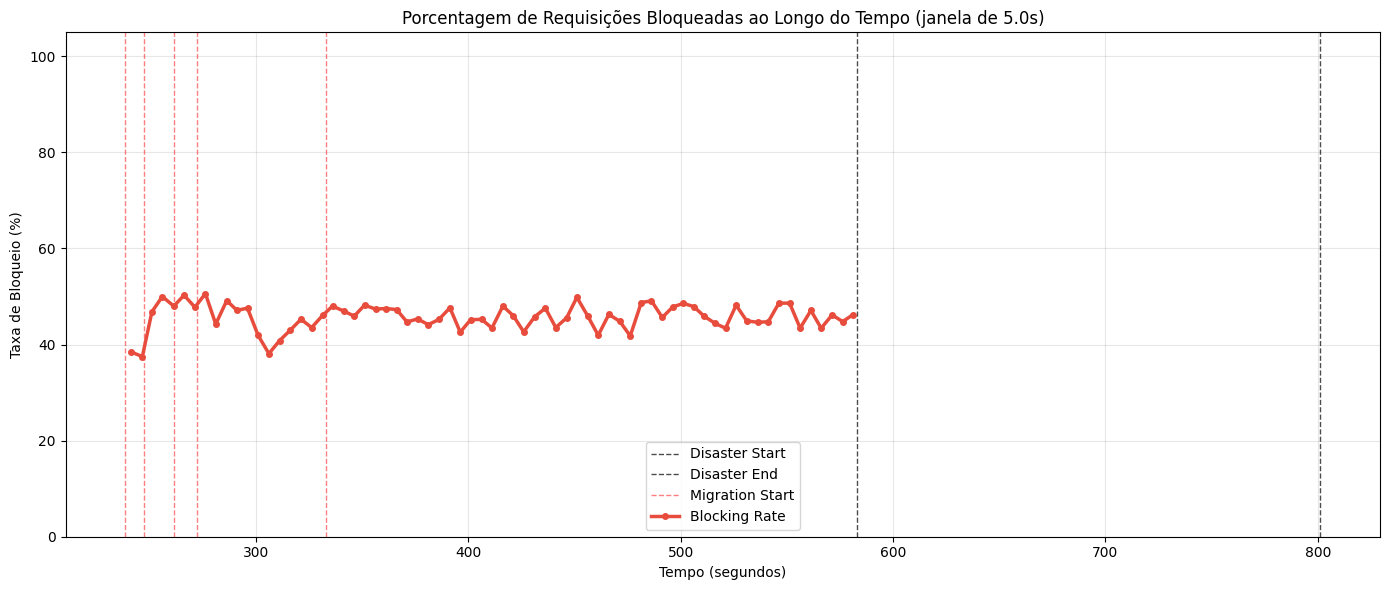

In [17]:
visualization.traffic_plots.plot_blocking_percentage_over_time(
    dataframe2[dataframe2["requisicao_de_migracao"]==True],
    scenario=cenario1,

)

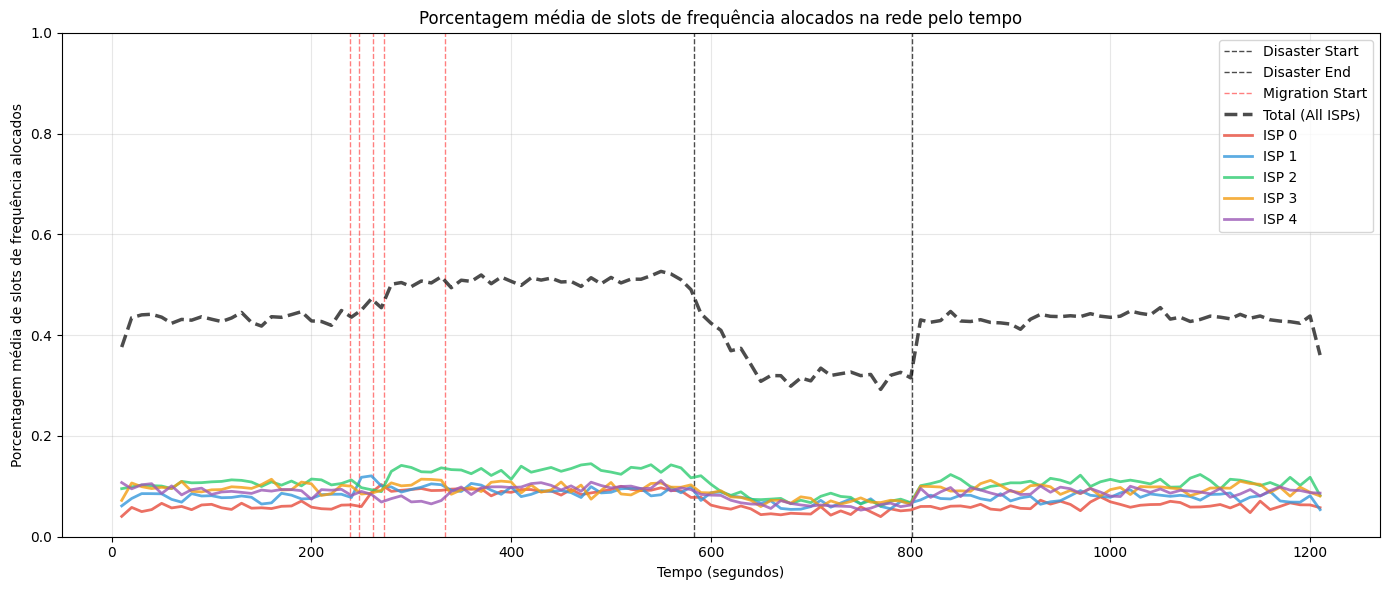

In [18]:
visualization.traffic_plots.plot_network_usage(dataframe1, TOPOLOGY, NUMERO_DE_SLOTS, scenario=cenario1, show_per_isp=True, )

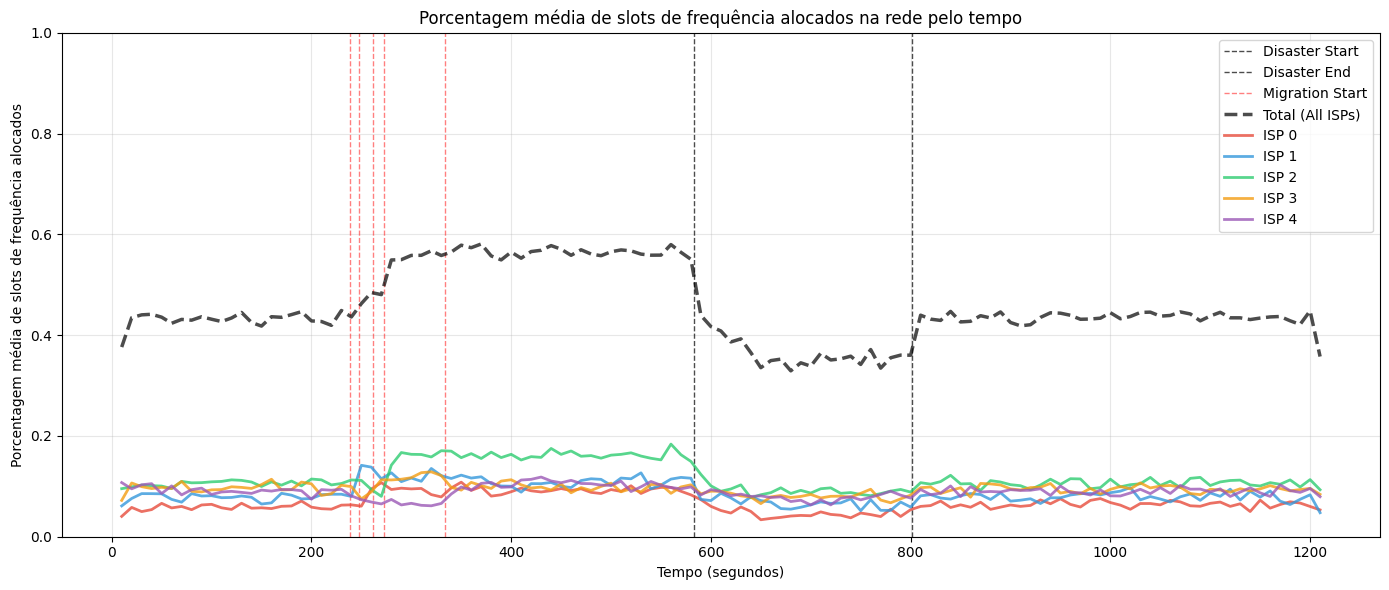

In [19]:
visualization.traffic_plots.plot_network_usage(dataframe2, TOPOLOGY, NUMERO_DE_SLOTS, scenario=cenario2, show_per_isp=True, )

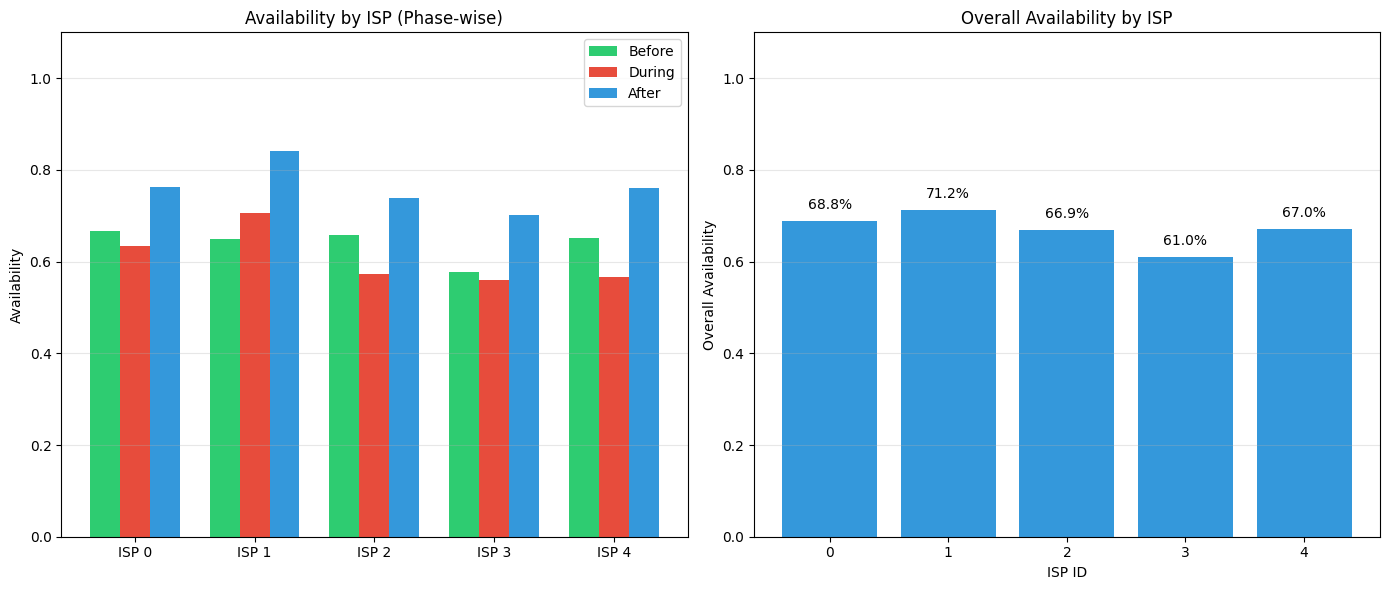

In [20]:
visualization.availability_plots.plot_availability_by_isp(dataframe1, cenario1, DISASTER_START, DISASTER_END)
#visualization.availability_plots.plot_isp_traffic_comparison(dataframe1, cenario1)

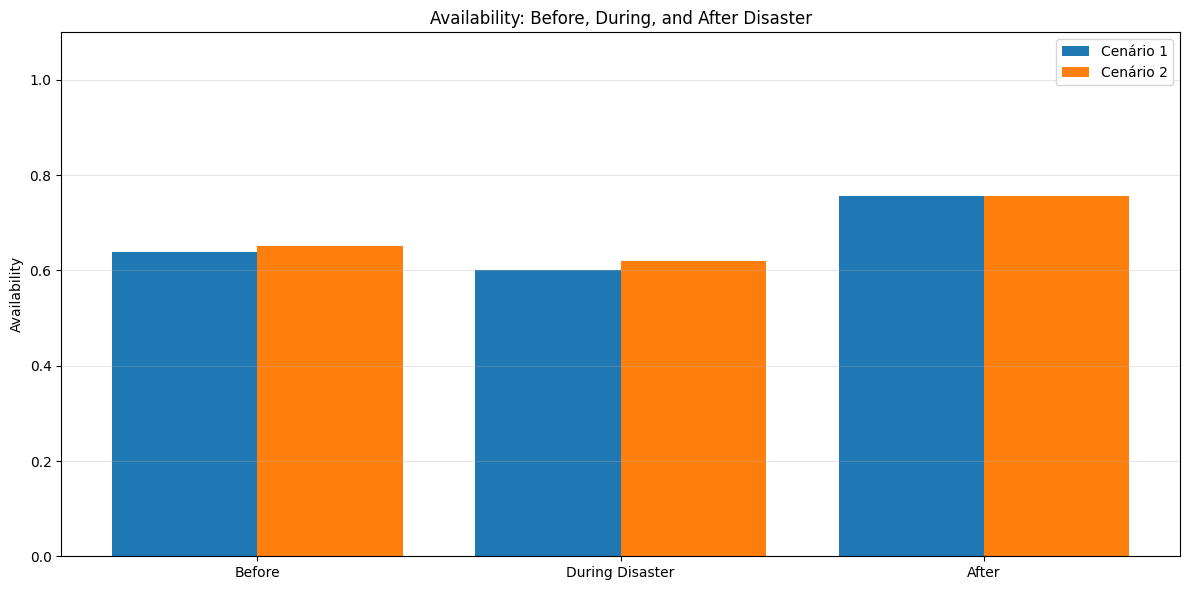

In [21]:
visualization.availability_plots.plot_availability_before_during_after({"Cenário 1": dataframe1, "Cenário 2": dataframe2}, DISASTER_START, DISASTER_END)

plt.show()


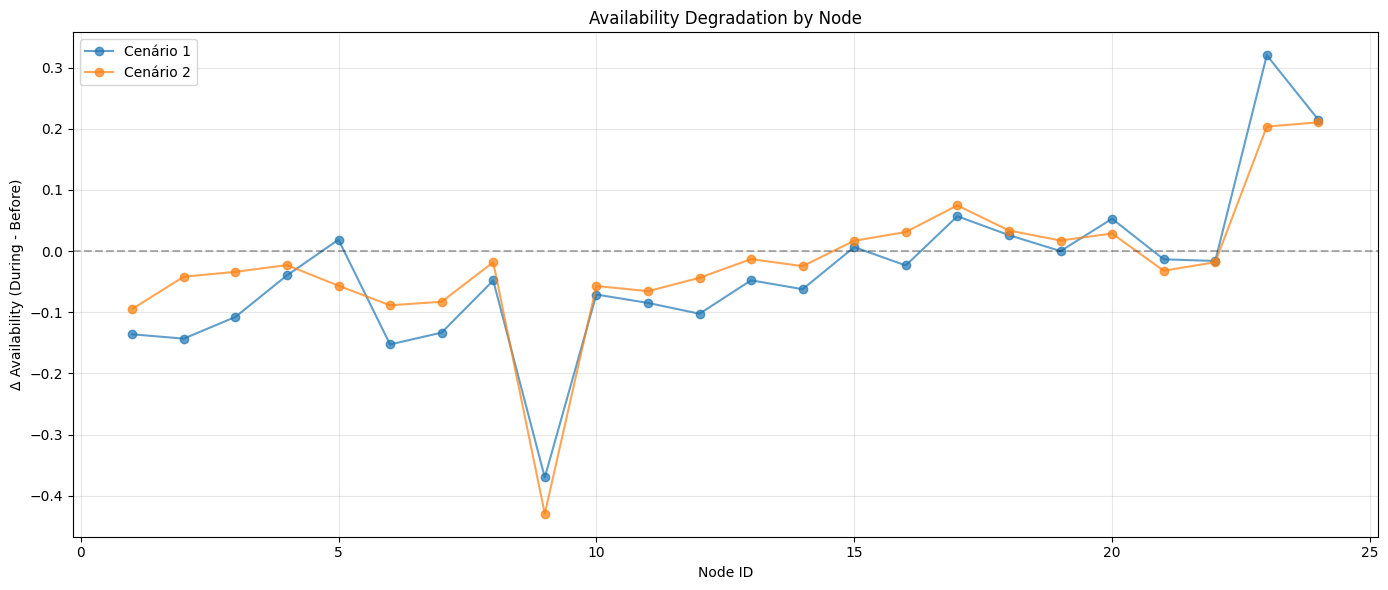

In [22]:
visualization.availability_plots.plot_delta_availability({"Cenário 1": dataframe1, "Cenário 2": dataframe2}, DISASTER_START, DISASTER_END)

plt.show()


In [23]:
visualization.traffic_plots.plot_network_usage(dataframe1, TOPOLOGY, scenario=cenario1, numero_de_slots=CONFIG.numero_de_slots)

NameError: name 'CONFIG' is not defined

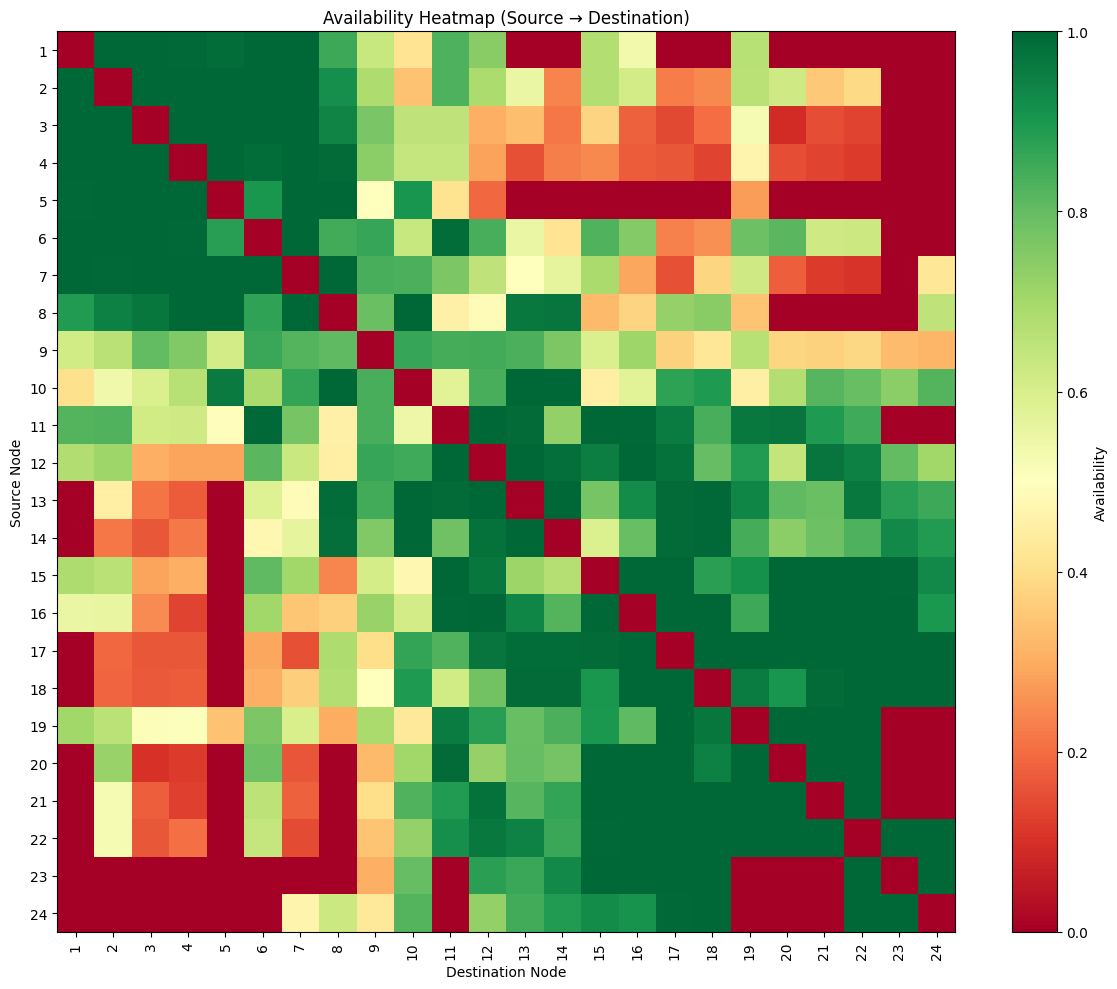

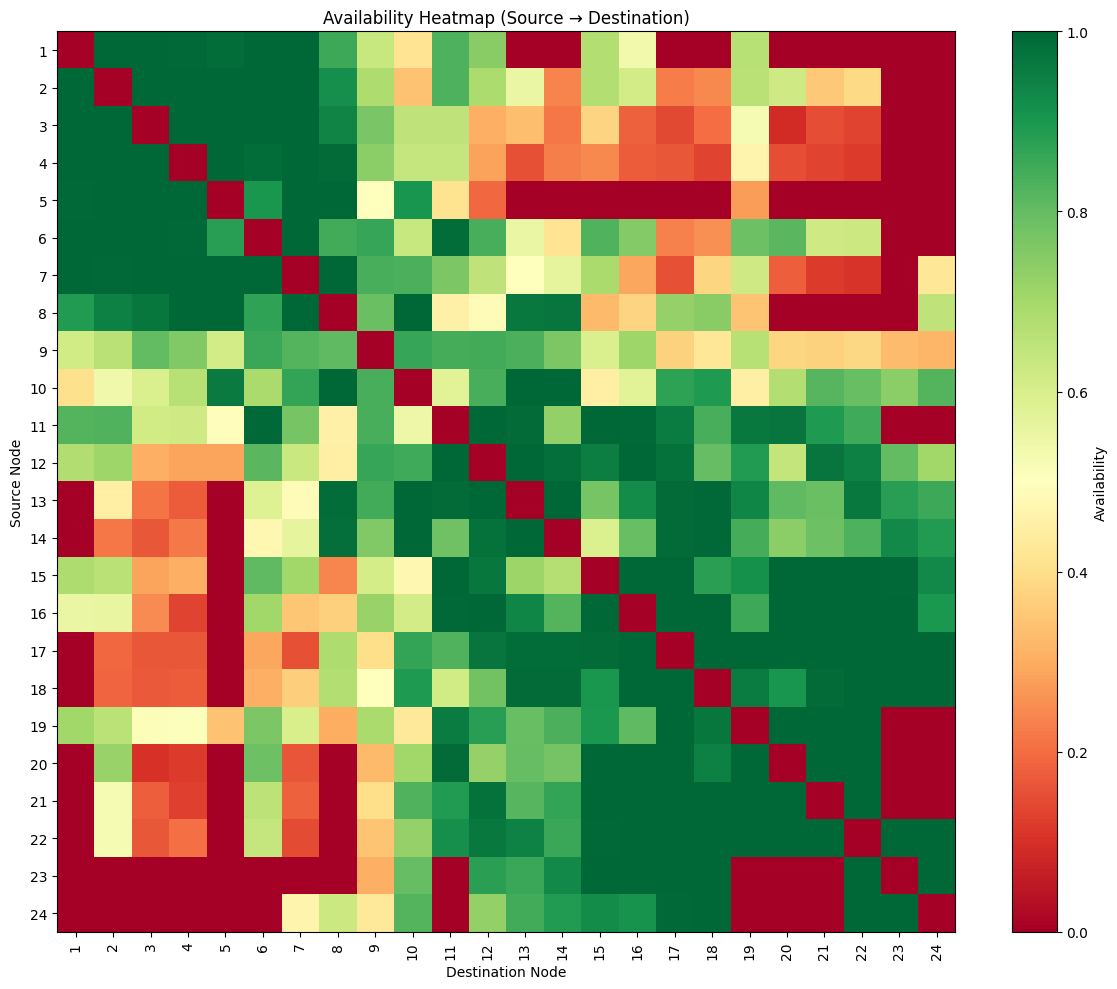

In [ ]:
visualization.availability_plots.plot_availability_heatmap(dataframe1, TOPOLOGY)

In [ ]:
numero_de_slots_dataframe1 = metrics_calculator.get_slots_allocated_during_disaster(dataframe1, DISASTER_START, DISASTER_END)
numero_de_slots_dataframe2 = metrics_calculator.get_slots_allocated_during_disaster(dataframe2, DISASTER_START, DISASTER_END)
print("numero de slots dataframe1", numero_de_slots_dataframe1)
print("numero de slots dataframe2", numero_de_slots_dataframe2)

NameError: name 'metrics_calculator' is not defined

Considerar fazer uma sliding window por distancia de par de nodes e considerar implementar bloqueio artificial em trafego intracomponente de maneira a facilitar alocação extra componente

analise comparativa de numero de slots alocados por node
